In [4]:
import numpy as np
filepath = 'D:/python3/Riboformer/Riboformer-main/datasets/GSE139036_disome/'

## load sample processed datasets
## https://github.com/lingxusb/Riboformer/tree/main/datasets/GSE139036_disome
x_c_total = np.loadtxt(filepath + 'subsample_xc' +'.txt',  delimiter="\t")    
y_c_total = np.loadtxt(filepath + 'subsample_yc'  +'.txt',  delimiter="\t") 
z_c_total = np.loadtxt(filepath + 'subsample_zc'  +'.txt',  delimiter="\t") 

print("finish loading the datasets.")

finish loading the datasets.


In [5]:
print(x_c_total.shape, y_c_total.shape, z_c_total.shape)

(4000, 82) (4000,) (4000, 4)


Ribosome density mean: 41.8086
Total sites to analyze: 4000


C:\Users\shaob\AppData\Local\Temp\ipykernel_40360\383296867.py:24: RuntimeWarning: invalid value encountered in divide
  norm_sample2 = window_sample2 / np.mean(window_sample2)


[[917, 4.283950118081596e-07, 6.295384615384616, 13.396358649835, 22.037275976435], [1076, 2.0167727664405977e-31, 23.047619047619047, 14.983357263655002, 84.27945438964001], [1470, 2.13842760431953e-76, 2.1927789699682534, 835.7944032577196, 1834.0126682455011], [1498, 5.394724655959866e-195, 4.486568204576576, 410.57078910820013, 1685.7036652065997], [1532, 4.1296644810879524e-173, 9.356056776200662, 160.72354849676003, 597.6421775747799], [1568, 1.0640166033077556e-69, 4.529352226720648, 104.47822727277112, 1216.153462037288], [1593, 4.942109350090299e-194, 6.542060097290469, 161.05378226480008, 3054.4701703255523], [1634, 4.4031258223398005e-79, 3.3048449859123785, 421.05891561857976, 661.4789425580894], [1675, 1.6588560872173535e-87, 5.558196660482375, 90.56537571914998, 1509.4303614636967], [1734, 6.017232326289118e-98, 5.242695705773577, 124.45216594125017, 1104.3191934006438], [1824, 0.0, 15.353448442649205, 201.2721892914, 3345.812244989751], [1861, 3.5439255145198523e-193, 5.

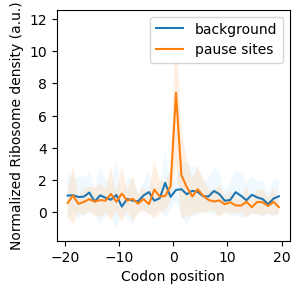

In [20]:
#### Record ribosome pause sites ####

from scipy.stats import fisher_exact
import matplotlib.pyplot as plt
import numpy as np

# Initialize
pause_site_records = []
pause_profiles_sample1 = []
pause_profiles_sample2 = []

# Print basic statistics
ribosome_density_mean = np.mean((np.power(2, y_c_total / 100) - 32) / 50)
print(f"Ribosome density mean: {ribosome_density_mean:.4f}")
print(f"Total sites to analyze: {len(z_c_total)}")

# Main loop
for pos in range(20, len(z_c_total) - 20):
    
    window_sample1 = (np.power(2, x_c_total[pos - 20: pos + 20, 20] / 100) - 32) / 50
    window_sample2 = (np.power(2, y_c_total[pos - 20: pos + 20] / 100) - 32) / 50
    
    norm_sample1 = window_sample1 / np.mean(window_sample1)
    norm_sample2 = window_sample2 / np.mean(window_sample2)
    
    # Progress update
    if pos % 20000 == 0:
        print(f"{pos} sites processed, {len(pause_site_records)} pause sites detected")
    
    # Criteria for identifying a pause site
    # Please note that there are a set of threshold to get the pause sites
    thres_coverage = 4
    thres_pvalue = 0.001
    thres_odds = 2
    if (
        z_c_total[pos - 20, 0] == z_c_total[pos + 20, 0]
        and window_sample1[20] > thres_coverage
        and window_sample2[20] > thres_coverage
        and window_sample2[20] == max(window_sample2)
    ):
        # Fisher's exact test
        oddsratio, pvalue = fisher_exact([
            [window_sample2[20], window_sample1[20]],
            [sum(window_sample2) - window_sample2[20], sum(window_sample1) - window_sample1[20]]
        ])
        
        if pvalue < thres_pvalue and oddsratio > thres_odds:
            pause_site_records.append([
                pos, pvalue, oddsratio, window_sample1[20], window_sample2[20]
            ])
            pause_profiles_sample1.append(norm_sample1)
            pause_profiles_sample2.append(norm_sample2)

# Print results
print(pause_site_records)
# Optional save
# np.savetxt('pause_indices.txt', pause_site_records, delimiter="\t") 

# Convert to arrays
pause_profiles_sample1 = np.array(pause_profiles_sample1)
pause_profiles_sample2 = np.array(pause_profiles_sample2)

# Plot
fig = plt.figure(figsize=(3, 3))
x_axis = np.arange(-19.5, 20.5)

mean_sample1 = np.mean(pause_profiles_sample1, axis=0)
std_sample1 = np.std(pause_profiles_sample1, axis=0)

mean_sample2 = np.mean(pause_profiles_sample2, axis=0)
std_sample2 = np.std(pause_profiles_sample2, axis=0)

plt.plot(x_axis, mean_sample1, label='background')
plt.fill_between(x_axis, mean_sample1 - std_sample1, mean_sample1 + std_sample1,
                 facecolor='#d8f0fe', alpha=0.4, edgecolor='none')

plt.plot(x_axis, mean_sample2, label='pause sites')
plt.fill_between(x_axis, mean_sample2 - std_sample2, mean_sample2 + std_sample2,
                 facecolor='#ffd9b7', alpha=0.4, edgecolor='none')
plt.xlabel('Codon position')
plt.ylabel('Normalized Ribosome density (a.u.)')
plt.legend()
plt.show()
